In [ ]:
!pip install  keras_unet segmentation_models tifffile patchify imagecodecs albumentations livelossplot

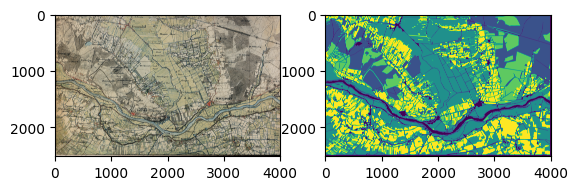

<ipython-input-5-ab8f88a54241>:75: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tif.imsave("mask_normalized2.tif",real_mask)


[0 1 2 3 4]


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif

###### Read images ######

main_img_path = "main_2.tiff"  # image 39
heath_img_path = "Heath_39_2_clipped_image_black.tif"
forest_img_path = "Forest_39_2_clipped_image_black.tif"
grassland_img_path = "Grassland_39_2_clipped_image_black.tif"
agriculture_img_path = "agriculture_39_2_clipped_image_black.tif"

# main_img_path = "main_1.tif"  # image 32
# heath_img_path = "heath_32_3_clipped_image.tif"
# forest_img_path = "forest_32_3_clipped_image.tif"
# grassland_img_path = "grassland_32_3_clipped_image.tif"
# agriculture_img_path = "agriculture_32_3_clipped_image.tif"

main_img = tif.imread(main_img_path)
heath_img = tif.imread(heath_img_path)
forest_img = tif.imread(forest_img_path)
grassland_img = tif.imread(grassland_img_path)
agriculture_img = tif.imread(agriculture_img_path)
# build a black mask

real_mask = np.zeros_like(forest_img)


###### colorizing the classes ######

real_mask[real_mask==heath_img] = 1
real_mask[real_mask==grassland_img] = 2
real_mask[real_mask==forest_img] = 3
real_mask[real_mask==agriculture_img] = 4

real_mask = cv.cvtColor(real_mask, cv.COLOR_RGB2GRAY)

# heath_loc = np.where(real_mask==1)
# grassland_loc = np.where(real_mask==2)
# forest_loc = np.where(real_mask==3)
# agriculture_loc = np.where(real_mask==4)

# for i in range(len(heath_loc[0])):
#     x = heath_loc[0][i]
#     y = heath_loc[1][i]
#     real_mask[x,y] = [0,0,255]

# for i in range(len(grassland_loc[0])):
#     x = grassland_loc[0][i]
#     y = grassland_loc[1][i]
#     real_mask[x,y] = [255,0,0]

# for i in range(len(forest_loc[0])):
#     x = forest_loc[0][i]
#     y = forest_loc[1][i]
#     real_mask[x,y] = [0,255,0]

# for i in range(len(agriculture_loc[0])):
#     x = agriculture_loc[0][i]
#     y = agriculture_loc[1][i]
#     real_mask[x,y] = [255,255,0]


###### plot colorized mask ######

plt.Figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(main_img)
plt.subplot(122)
plt.imshow(real_mask)
plt.show()

# tif.imsave("mask_normalized1.tif",real_mask)
tif.imsave("mask_normalized2.tif",real_mask)
print(np.unique(real_mask))

In [ ]:
import glob
import tifffile as tif
import cv2 as cv
import albumentations as A
from tqdm import tqdm
from patchify import patchify
import numpy as np
import os

# Create directories to store images and masks
os.makedirs("/content/for_test/img", exist_ok=True)
os.makedirs("/content/for_test/mask", exist_ok=True)

os.makedirs("/content/images", exist_ok=True)
os.makedirs("/content/masks", exist_ok=True)

################ data preparation ###############

# main_list = sorted(glob.glob("C:/map_data/main_*"))
# masks_list = sorted(glob.glob("mask_normalized*"))

main_list = sorted(glob.glob("main_*"))
masks_list = sorted(glob.glob("mask_norm*"))


print(main_list)
print(masks_list)

for i in range(len(main_list)):
  image = tif.imread(main_list[i])
  image = cv.resize(image, (4096,2560), interpolation=cv.INTER_NEAREST)

  mask = tif.imread(masks_list[i])
  mask = cv.resize(mask, (4096,2560), interpolation=cv.INTER_NEAREST)

  image_patches = patchify(image, patch_size=(256,256,3), step=128)
  mask_patches = patchify(mask, patch_size=(256,256), step=128)

  image_patches = np.reshape(image_patches, (-1,256,256,3))
  mask_patches = np.reshape(mask_patches, (-1,256,256))

  for j in tqdm(range(image_patches.shape[0])):
    if j<11 :
      img = image_patches[j]
      mask = mask_patches[j]

      transform = A.Compose([A.HorizontalFlip(p=0.2), A.RandomBrightnessContrast(p=0.3), A.GaussNoise(p=0.5), A.GaussianBlur(p=.1)])

      transformed = transform(image=img, mask=mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']

      tif.imwrite( "/content/for_test/img/image_" + str(i) + "_" + str(j) + ".tif" ,transformed_image)
      tif.imwrite( "/content/for_test/mask/mask_" + str(i) + "_" + str(j) + ".tif" ,transformed_mask)



    else:

      img = image_patches[j]
      mask = mask_patches[j]

      transform = A.Compose([A.HorizontalFlip(p=0.2), A.RandomBrightnessContrast(p=0.3), A.GaussNoise(p=0.5), A.GaussianBlur(p=.1)])

      transformed = transform(image=img, mask=mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']

      tif.imwrite( "/content/images/image_" + str(i) + "_" + str(j) + ".tif" ,transformed_image)
      tif.imwrite( "/content/masks/mask_" + str(i) + "_" + str(j) + ".tif" ,transformed_mask)


['main_1.tif', 'main_2.tiff']
['mask_normalized1.tif', 'mask_normalized2.tif']


100%|██████████| 589/589 [00:08<00:00, 65.53it/s]


In [ ]:
################### Libraries ###################
import cv2 as cv
import numpy as np
from keras_unet.models import custom_unet
from patchify import patchify,unpatchify
import segmentation_models as sm
import tifffile as tif
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import load_model
import os
from keras.utils import to_categorical
import keras
import livelossplot as llp
import pandas as pd
from keras.metrics import MeanIoU
import glob


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Segmentation Models: using `keras` framework.


In [ ]:
################ Create a dataset ###############

image_dir = "/content/images/"
mask_dir = "/content/masks/"

image_dataset=[]
mask_dataset=[]

image_list=sorted(os.listdir(image_dir))
mask_list=sorted(os.listdir(mask_dir))

for img in tqdm(image_list) :
    image = tif.imread(image_dir + img)
    image_dataset.append(image)

for msk in tqdm(mask_list) :
    mask = tif.imread(mask_dir + msk)
    mask_dataset.append(mask)

image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)
mask_dataset=np.expand_dims(mask_dataset, axis=3)

100%|██████████| 1156/1156 [00:00<00:00, 1709.99it/s]


In [ ]:
################ Split a dataset ################

x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset,
                                                    test_size=0.2, random_state=11)

def data_summary(x_train,x_test,y_train,y_test):
    print("x_train shape is :", x_train.shape)
    print("x_test shape is :", x_test.shape)
    print("y_train shape is :", y_train.shape)
    print("y_test shape is :", y_test.shape)
    print("e.g. y_train[1] pixel values contatins :", np.unique(y_train[1]))

data_summary(x_train,x_test,y_train,y_test)

x_train shape is : (924, 256, 256, 3)
x_test shape is : (232, 256, 256, 3)
y_train shape is : (924, 256, 256, 1)
y_test shape is : (232, 256, 256, 1)
e.g. y_train[1] pixel values contatins : [0 1 2 3 4]


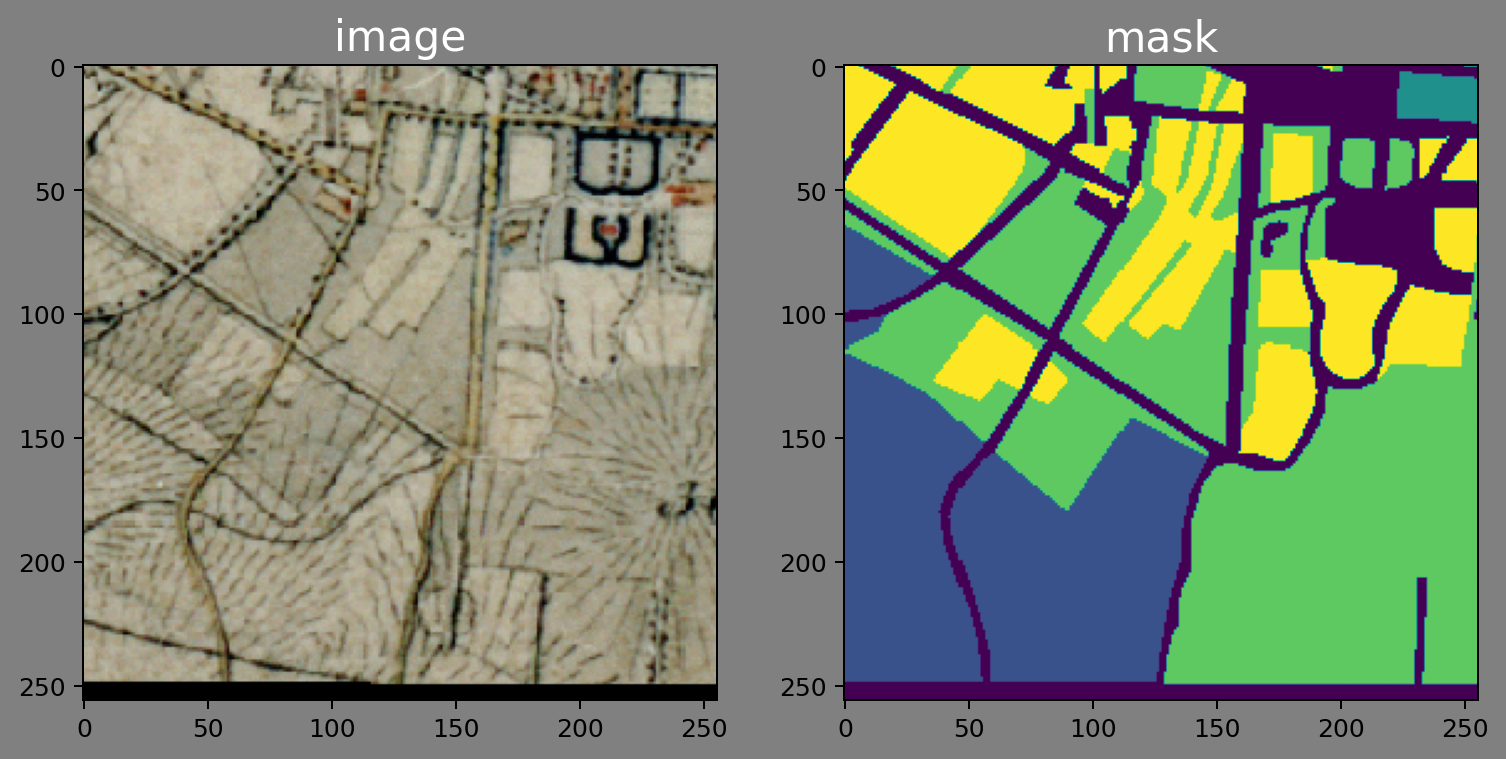

In [ ]:
################# sanity check ##################

rand_num = np.random.randint(0 , x_train.shape[0])

plt.figure(figsize=(10,10), facecolor="gray", dpi=180)
plt.subplot(1,2,1)
plt.imshow(x_train[rand_num])
plt.title("image", color="white", fontsize=17)
plt.subplot(1,2,2)
plt.imshow(y_train[rand_num])
plt.title("mask", color="white", fontsize=17,)
plt.show()

In [ ]:

############### Data preprocessing ##############
y_train = to_categorical(y_train , num_classes=5)
y_test = to_categorical(y_test , num_classes=5)


############# Define loss and metric ############

loss = sm.losses.DiceLoss()
metric = sm.metrics.IOUScore(threshold=0.5)


############### Define a callback ###############

filepath="/content/weights/map_seg_{epoch}_{val_iou_score}.hdf5"
checkpoint=keras.callbacks.ModelCheckpoint(filepath, monitor="val_iou_score",
                                            save_best_only=True, verbose=1, mode="max")

Live_loss= llp.PlotLossesKeras()


In [ ]:
############### Build U-net model ###############

model = custom_unet((256,256,3),
                    num_classes=5,
                    dropout_type="standard",
                    output_activation="softmax")


model.summary()

print(model.input_shape)
print(model.output_shape)

lr=0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=[loss],
              metrics=[metric])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         432       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['batch_normalization[0][0

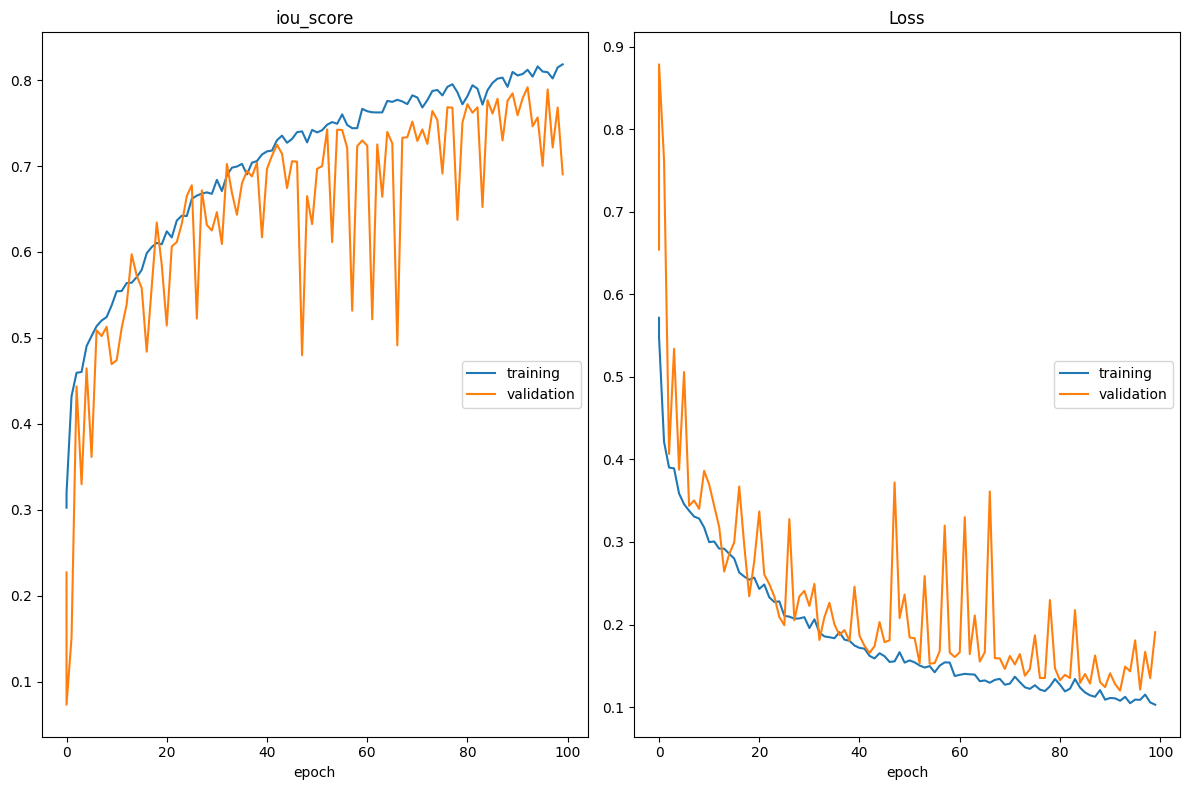

iou_score
	training         	 (min:    0.303, max:    0.818, cur:    0.818)
	validation       	 (min:    0.073, max:    0.792, cur:    0.690)
Loss
	training         	 (min:    0.103, max:    0.571, cur:    0.103)
	validation       	 (min:    0.120, max:    0.878, cur:    0.191)
116/116 [==============================] - 16s 134ms/step - loss: 0.1029 - iou_score: 0.8183 - val_loss: 0.1907 - val_iou_score: 0.6904


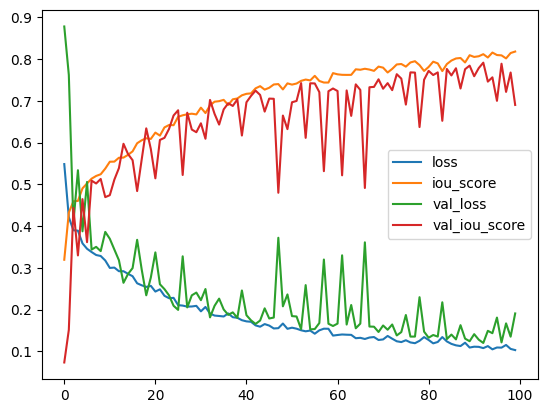

In [ ]:
################# fit the model #################

history = model.fit(x_train, y_train, epochs=100,
                    validation_data=(x_test,y_test),
                    batch_size=8, callbacks=[checkpoint,Live_loss])

model.save("map_seg_new.hdf5")
pd.DataFrame(history.history).plot()
plt.show()


8/8 [==============================] - 51s 6s/step


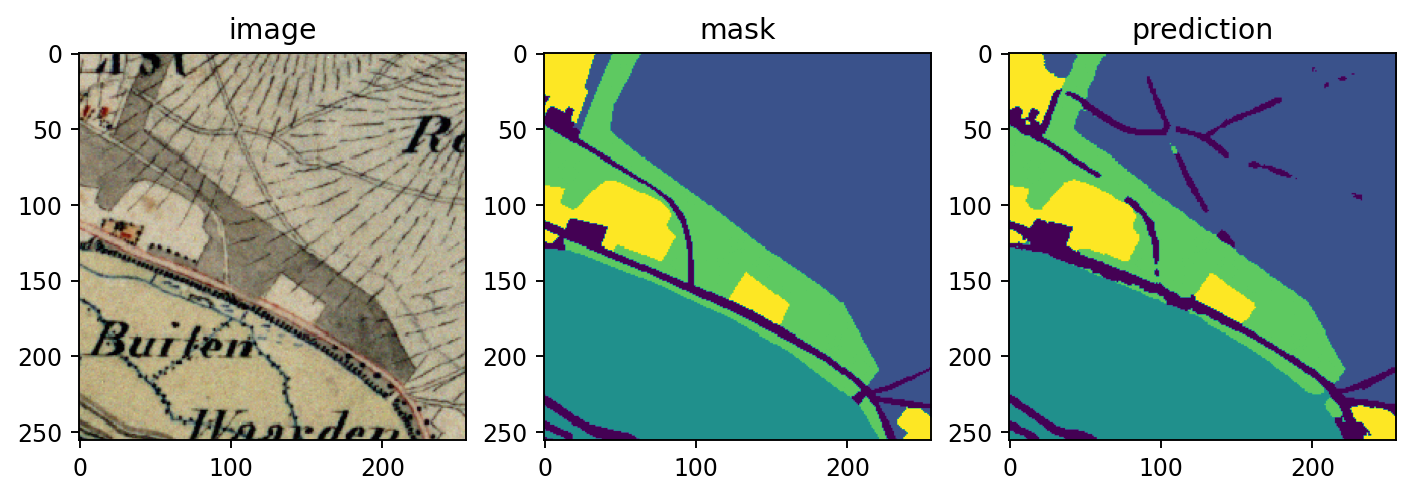

Mean IoU = 0.69402075
Dice Score for image 0 is : 0.6395444726306037
Dice Score for image 1 is : 0.8707665338393792
Dice Score for image 2 is : 0.922698875054056
Dice Score for image 3 is : 0.3458547030811137
Dice Score for image 4 is : 0.9385294675313507
Dice Score for image 5 is : 0.953353168512242
Dice Score for image 6 is : 0.9255990740775741
Dice Score for image 7 is : 0.8894172510219138
Dice Score for image 8 is : 0.9488692430217379
Dice Score for image 9 is : 0.9189449301594725
Dice Score for image 10 is : 0.8384535944087368
Dice Score for image 11 is : 0.989853438560878
Dice Score for image 12 is : 0.8332600442979654
Dice Score for image 13 is : 0.7524658054642075
Dice Score for image 14 is : 0.4854467333713593
Dice Score for image 15 is : 0.5282279350058646
Dice Score for image 16 is : 0.8391517973040691
Dice Score for image 17 is : 0.8086204010378855
Dice Score for image 18 is : 0.9042456148940715
Dice Score for image 19 is : 0.8895068766138682
Dice Score for image 20 is : 0.

In [ ]:
########## Model performance evaluation #########

my_model = load_model("map_seg_new.hdf5",compile=False)

# test_img = tif.imread("C:/map_data/for_test/img/image_0_4.tif")
# test_img = np.expand_dims(test_img, axis=0)

y_pred = my_model.predict(x_test)
y_pred_argmax = np.argmax(y_pred , axis=3)
y_test_argmax = np.argmax(y_test , axis=3)

random_img=np.random.randint(0,x_test.shape[0])
plt.figure(figsize=(10,10), dpi=170)
plt.subplot(131)
plt.imshow(x_test[random_img])
plt.title("image")

plt.subplot(132)
plt.imshow(y_test_argmax[random_img])
plt.title("mask")

plt.subplot(133)
plt.imshow(y_pred_argmax[random_img])
plt.title("prediction")
plt.show()


############# MeanIoU calculation ###############

num_classes = 5
IOU_keras = MeanIoU(num_classes=num_classes)
IOU_keras.update_state(y_pred_argmax,y_test_argmax)
print("Mean IoU =", IOU_keras.result().numpy())




In [ ]:
############### Dice calculation ################

def dice_score(y_test,y_pred):

    mean_dice = 0
    smooth = 0.0001
    for i in range(x_test.shape[0]):

        test_mask = y_test[i]
        test_pred = y_pred[i]

        intersection = np.sum(test_mask[test_mask==test_pred])
        dice = (2. * intersection + smooth) / (np.sum(test_mask) + np.sum(test_pred) + smooth)
        print(f"Dice Score for image {i} is : {dice}")
        mean_dice += dice
    print(f"Mean Dice score for all images is : {mean_dice/x_test.shape[0]}")


dice_score(y_test_argmax, y_pred_argmax)

Dice Score for image 0 is : 0.6395444726306037
Dice Score for image 1 is : 0.8707665338393792
Dice Score for image 2 is : 0.922698875054056
Dice Score for image 3 is : 0.3458547030811137
Dice Score for image 4 is : 0.9385294675313507
Dice Score for image 5 is : 0.953353168512242
Dice Score for image 6 is : 0.9255990740775741
Dice Score for image 7 is : 0.8894172510219138
Dice Score for image 8 is : 0.9488692430217379
Dice Score for image 9 is : 0.9189449301594725
Dice Score for image 10 is : 0.8384535944087368
Dice Score for image 11 is : 0.989853438560878
Dice Score for image 12 is : 0.8332600442979654
Dice Score for image 13 is : 0.7524658054642075
Dice Score for image 14 is : 0.4854467333713593
Dice Score for image 15 is : 0.5282279350058646
Dice Score for image 16 is : 0.8391517973040691
Dice Score for image 17 is : 0.8086204010378855
Dice Score for image 18 is : 0.9042456148940715
Dice Score for image 19 is : 0.8895068766138682
Dice Score for image 20 is : 0.813670334466209
Dice S

Dice Score for image 0 is : 0.6395444726306037
Dice Score for image 1 is : 0.8707665338393792
Dice Score for image 2 is : 0.922698875054056
Dice Score for image 3 is : 0.3458547030811137
Dice Score for image 4 is : 0.9385294675313507
Dice Score for image 5 is : 0.953353168512242
Dice Score for image 6 is : 0.9255990740775741
Dice Score for image 7 is : 0.8894172510219138
Dice Score for image 8 is : 0.9488692430217379
Dice Score for image 9 is : 0.9189449301594725
Dice Score for image 10 is : 0.8384535944087368
Dice Score for image 11 is : 0.989853438560878
Dice Score for image 12 is : 0.8332600442979654
Dice Score for image 13 is : 0.7524658054642075
Dice Score for image 14 is : 0.4854467333713593
Dice Score for image 15 is : 0.5282279350058646
Dice Score for image 16 is : 0.8391517973040691
Dice Score for image 17 is : 0.8086204010378855
Dice Score for image 18 is : 0.9042456148940715
Dice Score for image 19 is : 0.8895068766138682
Dice Score for image 20 is : 0.813670334466209
Dice S

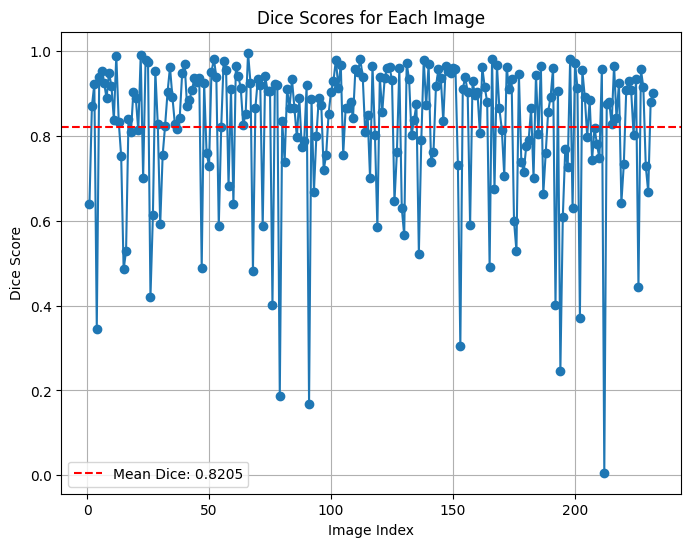

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def dice_score(y_test, y_pred):

    mean_dice = 0
    smooth = 0.0001
    dice_scores = []

    for i in range(y_test.shape[0]):

        test_mask = y_test[i]
        test_pred = y_pred[i]

        intersection = np.sum(test_mask[test_mask == test_pred])
        dice = (2. * intersection + smooth) / (np.sum(test_mask) + np.sum(test_pred) + smooth)

        print(f"Dice Score for image {i} is : {dice}")

        dice_scores.append(dice)
        mean_dice += dice

    mean_dice /= y_test.shape[0]
    print(f"Mean Dice score for all images is : {mean_dice}")

    # Plot the Dice scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, y_test.shape[0] + 1), dice_scores, marker='o', linestyle='-')
    plt.axhline(mean_dice, color='r', linestyle='--', label=f'Mean Dice: {mean_dice:.4f}')
    plt.title('Dice Scores for Each Image')
    plt.xlabel('Image Index')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)
    plt.show()

dice_score(y_test_argmax, y_pred_argmax)
